# MC866 Project 1

## PART I - Clustering Methods

https://towardsdatascience.com/the-5-clustering-algorithms-data-scientists-need-to-know-a36d136ef68

## Clustering using Expectation–Maximization (EM) Gaussian Mixture Model (GMM)

In [671]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import decomposition
import matplotlib
import math
import time
import matplotlib.cm as cm
from scipy.stats import multivariate_normal

In [672]:
class GMM:
    def __init__(self, data, n_clusters=3, random_state=None):
        self.n_clusters = n_clusters
        self.data = data
        self.rand = np.random.RandomState(random_state)
        self.means = []
        self.covs = []

    def init_clusters(self):
        cluster = np.array_split(self.rand.permutation(self.data), self.n_clusters)
        for c in cluster:
            self.means = np.append(self.means, np.mean(c, axis=0))
            self.covs = np.append(self.covs, np.cov(c.T))
        self.means = self.means.reshape(self.n_clusters, 2)
        self.covs = self.covs.reshape(self.n_clusters, 2, 2)

    def __probabilities_by_cluster(self, data=None):
        if data is None:
            data = self.data

        probabilities = np.array([])
        for i in range(0, self.n_clusters):
            var = multivariate_normal(mean=self.means[i], cov=self.covs[i], allow_singular=True)
            probabilities = np.append(probabilities, np.array([var.pdf(d) for d in data]))
        
        probabilities = probabilities.reshape((self.n_clusters, len(data)))
        return probabilities.T

    def aic(self):
        probabilities = self.__probabilities_by_cluster()
        probabilities = np.max(probabilities, axis=1) # get only the max probability for each data point
        aic = 2*self.data.shape[1] - 2*np.log(probabilities) # 2*p - 2*ln(L)
        return aic.sum()

    def bic(self):
        probabilities = self.__probabilities_by_cluster()
        probabilities = np.max(probabilities, axis=1) # get only the max probability for each data point
        bic = -2*np.log(probabilities) + self.data.shape[1]*math.log(self.data.shape[0]) # -2*ln(L)+ p*ln(N)
        return bic.sum()

    def clusters(self, data=None):
        probabilities = self.__probabilities_by_cluster(data=data)
        return np.argmax(probabilities, axis=1) 

    def fit(self):
        start_time = time.time()
        iterations = 0
        while True:
            iterations += 1
            clusters = self.clusters()
            changed = False
            for i in range(0, self.n_clusters):
                data_filter = clusters == i
                filtered_data = self.data[data_filter] # only data that belongs to the cluster
                if len(filtered_data) > 1: # can't calculate cov matrix for only one data point
                    mean = np.sum(filtered_data, axis=0)
                    mean = mean/filtered_data.shape[0]
                    cov = np.cov(filtered_data.T)
                    for j in range (0, mean.shape[0]):
                        if self.means[i][j] != mean[j]:
                            changed = True
                            self.means[i][j] = mean[j]
                            self.covs[i] = cov
                        
            if not changed:
                break
        
        print(f"converged in {iterations} iterations")
        print("--- %s seconds ---" % (time.time() - start_time))

### The Dataset
First we will run tests using the provided 2d dataset, splitting it in 90% for training and 10% for test.

Afterwards we'll run the same proccess on another dataset with more dimensions.

In [673]:
df = pd.read_csv("./data/cluster.dat", sep=' ', header=None)
df.head()

msk = np.random.rand(len(df)) < 0.9 # split dataset (90% train and 10% test)

df_train = df[msk]
df_test = df[~msk]

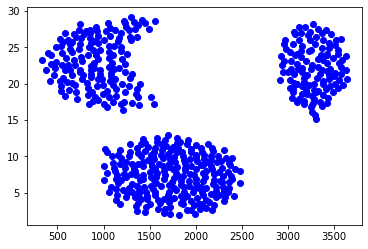

In [674]:
# 2D dataset

fig, ax = plt.subplots()
ax.scatter(df_train.iloc[:,:1].values, df_train.iloc[:,1:].values, c="blue") # the data
plt.show()

By observing the visualization of the dataset, we can verify that 3 clusters would be adequate.

In [675]:
gmm = GMM(data=df_train.to_numpy(), n_clusters=3)

The clusters are initialy initialized with random points of the dataset provided for training.

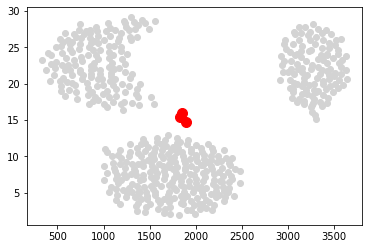

In [676]:
# initialize clusters and show their initial position in the chart
gmm.init_clusters()
    
fig, ax = plt.subplots()
ax.scatter(df_train.iloc[:,:1].values, df_train.iloc[:,1:].values, c="lightgray") # the data
ax.scatter(gmm.means[:,:1], gmm.means[:,1:], c="red", s=100) # the mean of each cluster
plt.show()

We use the clusters() method to get which cluster each data point has the highest probability of belonging

In [677]:
gmm.clusters()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

Initially without any fitting, the clusters provided are the following

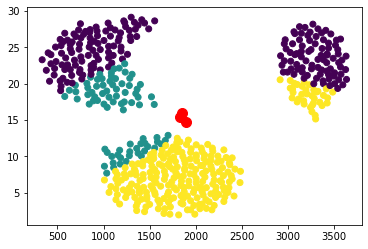

In [678]:
# initialize clusters and show their initial position in the chart

c = gmm.clusters()

fig, ax = plt.subplots()
ax.scatter(df_train.iloc[:,:1].values, df_train.iloc[:,1:].values, c=c) # the data
ax.scatter(gmm.means[:,:1], gmm.means[:,1:], c="red", s=100) # the mean of each cluster
plt.show()

In [679]:
gmm.fit()

converged in 9 iterations
--- 0.4445672035217285 seconds ---


### Results after fitting with the raw training data

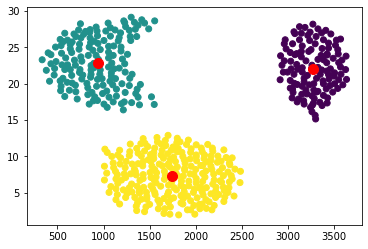

In [680]:
# Result of clusters after fitting is done

c = gmm.clusters()

fig, ax = plt.subplots()
ax.scatter(df_train.iloc[:,:1].values, df_train.iloc[:,1:].values, c=c) # the data
ax.scatter(gmm.means[:,:1], gmm.means[:,1:], c="red", s=100) # the mean of each cluster
plt.show()

As we can see, despite the fact that X and Y are on different scales, the GMM algorithm converged to optimal clusters even without a prior data normalization (unlike k-means)

## Checking the test data distribution

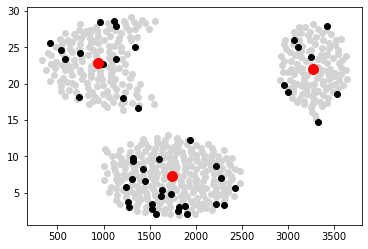

In [681]:
# the test data
fig, ax = plt.subplots()
ax.scatter(df_train.iloc[:,:1].values, df_train.iloc[:,1:].values, c="lightgray") # the data
ax.scatter(df_test.iloc[:,:1].values, df_test.iloc[:,1:].values, c="black") # the data
ax.scatter(gmm.means[:,:1], gmm.means[:,1:], c="red", s=100) # the mean of each cluster
plt.show()

## How the test data was classified using the prefitted gaussian mixture model

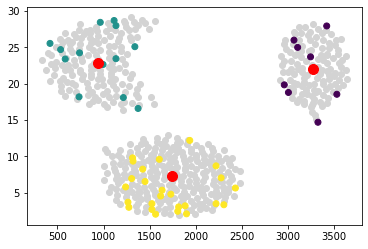

In [682]:
c = gmm.clusters(data=df_test.to_numpy())

fig, ax = plt.subplots()
ax.scatter(df_train.iloc[:,:1].values, df_train.iloc[:,1:].values, c="lightgray") # the data
ax.scatter(df_test.iloc[:,:1].values, df_test.iloc[:,1:].values, c=c) # the data
ax.scatter(gmm.means[:,:1], gmm.means[:,1:], c="red", s=100) # the mean of each cluster
plt.show()

### Metrics

Now we will verify the results using a few metrics.

### The AIC/BIC Method
We'll run the GMM algorithm with different amounts of clusters and calculate the AIC and BIC metrics for every run. 

converged in 2 iterations
--- 0.036416053771972656 seconds ---
converged in 4 iterations
--- 0.10275101661682129 seconds ---
converged in 9 iterations
--- 0.34458398818969727 seconds ---
converged in 26 iterations
--- 1.342674970626831 seconds ---
converged in 12 iterations
--- 0.7901129722595215 seconds ---
converged in 16 iterations
--- 1.3035399913787842 seconds ---
converged in 15 iterations
--- 1.4833991527557373 seconds ---
converged in 26 iterations
--- 2.800295829772949 seconds ---
converged in 27 iterations
--- 3.8470051288604736 seconds ---


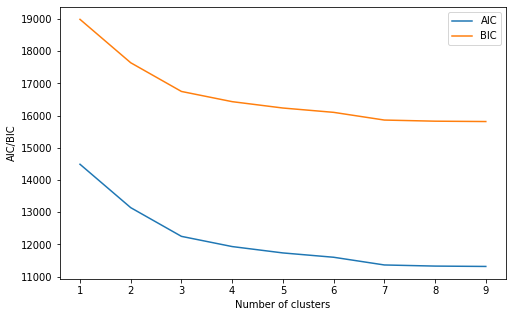

In [683]:
aic_values = []
bic_values = []
cluster_range = range(1, 10)
for i in cluster_range:
    gmm = GMM(data=df_train.to_numpy(), n_clusters=i)
    gmm.init_clusters()
    gmm.fit()
    aic_values.append(gmm.aic())
    bic_values.append(gmm.bic())

fig, ax = plt.subplots(figsize=(8,5))
ax.set_xlabel("Number of clusters")
ax.set_ylabel("AIC/BIC")
p1, = ax.plot(cluster_range, aic_values, label="AIC") # the data
p2, = ax.plot(cluster_range, bic_values, label="BIC") # the data
plt.legend(handles=[p1, p2])
plt.show()

With the elbow method we can easily verify that 3 clusters intuitively chosen really is the optimal amount. 

In [684]:
n_clusters = 3
data = df_train.to_numpy()
points = np.random.RandomState(None).permutation(data)[:n_clusters]
means = []
covs = []
for p in points:
    means = np.append(means, p)
    covs = np.append(covs, np.cov(p))
means = means.reshape(n_clusters, 2)

probabilities = np.array([])
for i in range(0, n_clusters):
    var = multivariate_normal(mean=means[i], cov=covs[i], allow_singular=True)
    probabilities = np.append(probabilities, np.array([var.pdf(d) for d in data]))

probabilities = probabilities.reshape((n_clusters, len(data)))
probabilities = probabilities.T
print(data[0])
print(probabilities)

np.argmax(probabilities, axis=1)

[1555.     28.65]
[[1.91089020e-07 1.94313337e-08 1.86570916e-07]
 [1.94922121e-07 1.90230862e-08 1.90058224e-07]
 [1.97002590e-07 1.87377222e-08 1.91922352e-07]
 ...
 [8.38983659e-09 2.64908404e-08 9.16031048e-09]
 [7.37818563e-09 2.64784356e-08 8.08927574e-09]
 [1.06203709e-08 2.64899155e-08 1.15073475e-08]]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,